In [39]:
import os

import google.generativeai as genai
import warnings
warnings.filterwarnings("ignore")

GOOGLE_API_KEY=os.getenv('GOOGLE_API_KEY')

genai.configure(api_key=GOOGLE_API_KEY)

from google.generativeai.types import HarmCategory, HarmBlockThreshold

def analyze_sentiment_gemini(text):
    model = genai.GenerativeModel('gemini-pro')
    message = "Analyze the following video comment and determine the sentiment score of a given text. Return answer in a single float ranging anywhere from -1 to 1, where -1 is negative sentiment, 0 is neutral sentiment, and 1 is positive sentiment: " + text
    try:
        response = model.generate_content(message, safety_settings={
            HarmCategory.HARM_CATEGORY_HATE_SPEECH: HarmBlockThreshold.BLOCK_NONE,
            HarmCategory.HARM_CATEGORY_HARASSMENT: HarmBlockThreshold.BLOCK_NONE,
            HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: HarmBlockThreshold.BLOCK_NONE
            }
        )
        return float(response.text)
    except AttributeError as e:
        model = genai.GenerativeModel('gemini-pro')
        return 0
    except Exception as e:
        model = genai.GenerativeModel('gemini-pro')
        return -0

In [40]:
from nltk.sentiment import SentimentIntensityAnalyzer


def analyze_sentiment_vader(text):
    # create a SentimentIntensityAnalyzer object
    sid_obj = SentimentIntensityAnalyzer()
    # polarity_scores method of SentimentIntensityAnalyzer
    # object gives a sentiment dictionary.
    # which contains pos, neg, neu, and compound scores.
    sentiment_dict = sid_obj.polarity_scores(text)
    return sentiment_dict['compound']

In [41]:
from textblob import TextBlob


def analyze_sentiment_textblob(text):
    # create a TextBlob object
    analysis = TextBlob(text)
    # return the sentiment
    return analysis.sentiment.polarity

In [42]:
def analyze_sentiment(text):
    sentiment_gemini = analyze_sentiment_gemini(text)
    sentiment_vader = analyze_sentiment_vader(text)
    sentiment_textblob = analyze_sentiment_textblob(text)
    return sentiment_gemini, sentiment_vader, sentiment_textblob

In [43]:
from matplotlib import pyplot as plt
import pandas as pd


def save_sentiment_score(file_name, data_directory, output_directory):
    with open(data_directory + file_name) as f:
        df = pd.read_csv(f)
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    # draw a histogram of the sentiment scores
    df['sentiment_gemini'] = df['comment'].apply(analyze_sentiment_gemini)
    df['sentiment_vader'] = df['comment'].apply(analyze_sentiment_vader)
    df['sentiment_textblob'] = df['comment'].apply(analyze_sentiment_textblob)
    
    # save the dataframe to a csv file
    df.to_csv(output_directory + file_name.split('.')[0].removesuffix('-cleaned') + '_sentiment_score.csv', index=False)
    video_title = file_name.split('.')[0].removesuffix('-cleaned')
    # draw a histogram of the sentiment scores
    plt.hist(df['sentiment_gemini'], bins=20, alpha=0.5, label='gemini', color='green')
    plt.hist(df['sentiment_vader'], bins=20, alpha=0.5, label='vader', color='blue')
    plt.hist(df['sentiment_textblob'], bins=20, alpha=0.5, label='textblob', color='red')
    plt.legend(loc='upper right')
    plt.title('Histogram of Sentiment Scores\n' + video_title)
    plt.xlabel('Sentiment Score')
    plt.ylabel('Frequency')
    plt.savefig(output_directory + file_name.split('.')[0] + '_sentiment.png')
    plt.show()

In [44]:
data_directory = '../preprocessed_data/'
output_directory = '../sentiment_data/sentiment_score/'
# Load the json files from the data directory
files = os.listdir(data_directory)
cleaned_files = [f for f in files if f.endswith('-cleaned.csv')]
cleaned_files

['CNN-Judge orders Trump to pay $355 million in civil fraud trial-cleaned.csv',
 'Fox News-Trump ordered to pay $364M, found liable in civil fraud trial-cleaned.csv']

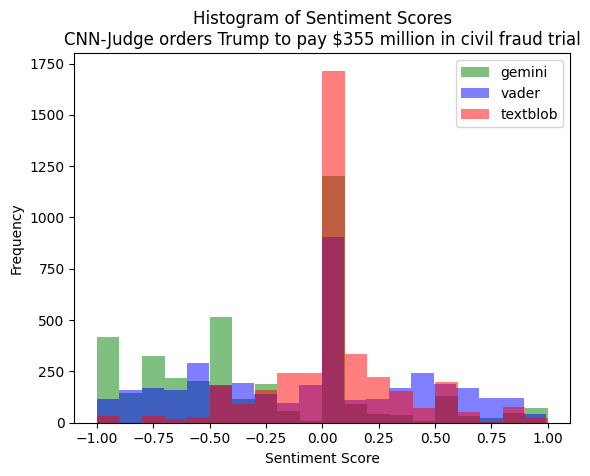

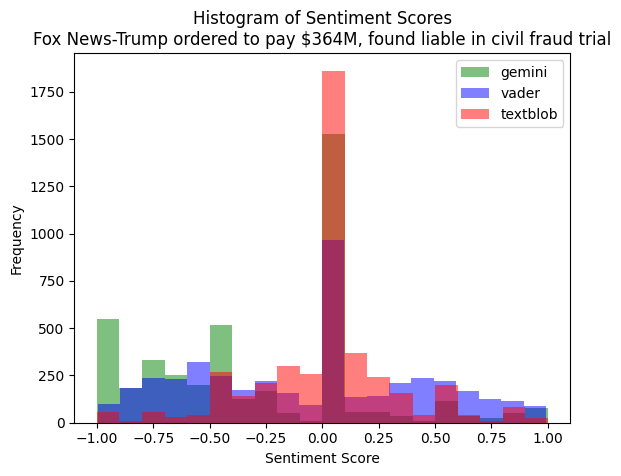

In [45]:
for file_name in cleaned_files:
    save_sentiment_score(file_name, data_directory, output_directory)

In [51]:
def filter_sentiment_score(file_name, data_directory, output_directory):
    with open(data_directory + file_name) as f:
        df = pd.read_csv(f)
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
        
    df1 = df[(df['sentiment_vader'] < -0.2) | (df['sentiment_vader'] > 0.2)]
    df2 = df[(df['sentiment_textblob'] < -0.2) | (df['sentiment_textblob'] > 0.2)]
    df3 = df[(df['sentiment_gemini'] < -0.2) | (df['sentiment_gemini'] > 0.2)]
    
    # sort the data by sentiment score
    df1 = df1.sort_values(by='sentiment_vader', ascending=False)
    df2 = df2.sort_values(by='sentiment_textblob', ascending=False)
    df3 = df3.sort_values(by='sentiment_gemini', ascending=False)
    
    # write the filtered data to a csv file and save it
    df1.to_csv(output_directory + file_name.split('.')[0].removesuffix("_sentiment_score") + '_vader.csv', index=False)
    df2.to_csv(output_directory + file_name.split('.')[0].removesuffix("_sentiment_score") + '_textblob.csv', index=False)
    df3.to_csv(output_directory + file_name.split('.')[0].removesuffix("_sentiment_score") + '_gemini.csv', index=False)

In [52]:
data_directory = '../sentiment_data/sentiment_score/'
output_directory = '../sentiment_data/sentiment_score/'
# Load the json files from the data directory
files = os.listdir(data_directory)
sentiment_files = [f for f in files if f.endswith('_sentiment_score.csv')]
sentiment_files

['Fox News-Trump ordered to pay $364M, found liable in civil fraud trial_sentiment_score.csv',
 'CNN-Judge orders Trump to pay $355 million in civil fraud trial_sentiment_score.csv']

In [53]:
for file_name in sentiment_files:
    filter_sentiment_score(file_name, data_directory, output_directory)

In [62]:
from sentence_transformers import SentenceTransformer
import pandas as pd
from sklearn.mixture import GaussianMixture as GMM
import os

os.environ['TOKENIZERS_PARALLELISM'] = 'false'

def cluster_sentiment_score(file_name, data_directory, output_directory, cluster_num=3):
    with open(data_directory + file_name) as f:
        df = pd.read_csv(f)
        
    # get the comments  
    comments = df['comment']    
    # load the pre-trained model
    model = SentenceTransformer('all-MiniLM-L6-v2')
    # encode the comments
    embeddings = df['comment'].map(lambda x: model.encode(x))
    
    # converts embeddings into a dataframe
    embeddings = embeddings.to_frame()
    embeddings = embeddings['comment'].apply(pd.Series)
    
    # fit the Gaussian Mixture Model
    gmm = GMM(n_components=cluster_num).fit(embeddings)
    # predict the cluster
    labels = gmm.predict(embeddings)
    # add the cluster to the dataframe
    df['cluster'] = labels
    # save the dataframe to a csv file
    df.to_csv(output_directory + file_name.split('.')[0] + '_clustered.csv', index=False)

In [63]:
def sort_cluster(file_name, data_directory, output_directory):
    with open(data_directory + file_name) as f:
        df = pd.read_csv(f)
    if 'vader' in file_name:
        if 'sentiment_textblob' in df.keys():
            df = df.drop(columns=['sentiment_textblob'])
        if 'sentiment_gemini' in df.keys():
            df = df.drop(columns=['sentiment_gemini'])
        df = df.sort_values(by=['cluster', 'sentiment_vader'], ascending=[True, False])
    elif 'textblob' in file_name:
        if 'sentiment_vader' in df.keys():
            df = df.drop(columns=['sentiment_vader'])
        if 'sentiment_gemini' in df.keys():
            df = df.drop(columns=['sentiment_gemini'])
        df = df.sort_values(by=['cluster', 'sentiment_textblob'], ascending=[True, False])
    else:
        # pass
        if 'sentiment_vader' in df.keys():
            df = df.drop(columns=['sentiment_vader'])
        if 'sentiment_textblob' in df.keys():
            df = df.drop(columns=['sentiment_textblob'])
        df = df.sort_values(by=['cluster', 'sentiment_gemini'], ascending=[True, False])
    df.to_csv(output_directory + file_name, index=False)

In [64]:
sentiment_data_path = '../sentiment_data/sentiment_score/'
cluster_path = '../sentiment_data/sentiment_cluster/'
files = os.listdir(sentiment_data_path)
clustering_file = [f for f in files if f.endswith('_gemini.csv') or f.endswith('_vader.csv') or f.endswith('_textblob.csv')]

In [67]:
for file_name in clustering_file:
    cluster_sentiment_score(file_name, sentiment_data_path, cluster_path)

In [68]:
files = os.listdir(cluster_path)
clustered_file = [f for f in files if f.endswith('_clustered.csv')]
# sort the data by cluster
for file in clustered_file:
    with open(sentiment_data_path + file) as f:
        df = pd.read_csv(f)
    if 'vader' in file:
        if 'sentiment_textblob' in df.keys():
            df = df.drop(columns=['sentiment_textblob'])
        if 'sentiment_gemini' in df.keys():
            df = df.drop(columns=['sentiment_gemini'])
        df = df.sort_values(by=['cluster', 'sentiment_vader'], ascending=[True, False])
    elif 'textblob' in file:
        if 'sentiment_vader' in df.keys():
            df = df.drop(columns=['sentiment_vader'])
        if 'sentiment_gemini' in df.keys():
            df = df.drop(columns=['sentiment_gemini'])
        df = df.sort_values(by=['cluster', 'sentiment_textblob'], ascending=[True, False])
    else:
        # pass
        if 'sentiment_vader' in df.keys():
            df = df.drop(columns=['sentiment_vader'])
        if 'sentiment_textblob' in df.keys():
            df = df.drop(columns=['sentiment_textblob'])
        df = df.sort_values(by=['cluster', 'sentiment_gemini'], ascending=[True, False])
    df.to_csv(sentiment_data_path + file, index=False)

In [84]:
# segregate positive and negative comments
from sentence_transformers import SentenceTransformer
import pandas as pd
from sklearn.mixture import GaussianMixture as GMM
import os
# for file in clustered_file:
def positive_clustering(file_name, data_directory, output_directory, cluster_num=3):
    with open(data_directory + file_name) as f:
        df = pd.read_csv(f)
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    positive_comments = df[df['sentiment_gemini'] > 0.7]
    model = SentenceTransformer('all-MiniLM-L6-v2')
    embeddings = positive_comments['comment'].map(lambda x: model.encode(x))
    embeddings = embeddings.to_frame()
    embeddings = embeddings['comment'].apply(pd.Series)
    gmm = GMM(n_components=cluster_num).fit(embeddings)
    labels = gmm.predict(embeddings)
    positive_comments['cluster'] = labels
    # sort
    positive_comments = positive_comments.sort_values(by=['cluster', 'sentiment_gemini'], ascending=[True, False])
    positive_comments.to_csv(output_directory + file_name.split('.')[0].removesuffix("_clustered") + "_" + str(cluster_num) + "_cluster_positive.csv", index=False)
    
def negative_clustering(file_name, data_directory, output_directory, cluster_num=3):
    with open(data_directory + file_name) as f:
        df = pd.read_csv(f)
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    negative_comments = df[df['sentiment_gemini'] < -0.7]
    model = SentenceTransformer('all-MiniLM-L6-v2')
    embeddings = negative_comments['comment'].map(lambda x: model.encode(x))
    embeddings = embeddings.to_frame()
    embeddings = embeddings['comment'].apply(pd.Series)
    gmm = GMM(n_components=cluster_num).fit(embeddings)
    labels = gmm.predict(embeddings)
    negative_comments['cluster'] = labels
    # sort
    negative_comments = negative_comments.sort_values(by=['cluster', 'sentiment_gemini'], ascending=[True, False])
    negative_comments.to_csv(output_directory + file_name.split('.')[0].removesuffix("_clustered") + "_" + str(cluster_num) + "_cluster_negative.csv", index=False)

In [86]:
cluster_path = '../sentiment_data/sentiment_cluster/'
gemini_clustered_files = [f for f in clustered_file if f.endswith('_gemini_clustered.csv')]
for file_name in gemini_clustered_files:
    positive_clustering(file_name, cluster_path, cluster_path, 2)
    negative_clustering(file_name, cluster_path, cluster_path, 2)